# Pedestrian Detection using SVM and HOG

In [1]:
# 📦 Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import glob
from tqdm import tqdm


## 1. Load image paths and assign labels

In [2]:
# Define the path to the images with and without pedestrians
path_with_pedestrians = "bdd_people/with_people/train/*.jpg"
path_without_pedestrians = "bdd_people/without_people/train/*.jpg"

# Load up to 800 images per class, this bacause with all the image take more time
images_with_people = glob.glob(path_with_pedestrians)[:800]
images_without_people = glob.glob(path_without_pedestrians)[:800]

# Combine all image paths and labels
all_images = images_with_people + images_without_people
all_labels = [1] * len(images_with_people) + [0] * len(images_without_people)  # 1 = pedestrian, 0 = no pedestrian

print(f"🔍 Images with pedestrians: {len(images_with_people)}")
print(f"🔍 Images without pedestrians: {len(images_without_people)}")

🔍 Images with pedestrians: 800
🔍 Images without pedestrians: 800


## 2. Split image paths into train/test

In [3]:
# Use 80% of the data for training and 20% for testing
x_train_paths, x_test_paths, y_train_raw, y_test_raw = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

## 3. Extract HOG features from images

In [4]:
# Function to extract HOG features from an image path
def extract_hog(image_path, size=(128, 128)):
    image = imread(image_path)
    gray_image = rgb2gray(image)
    resized_image = resize(gray_image, size)
    features, _ = hog(resized_image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=True)
    return features

# Extract HOG features for training and test images
X_train = [extract_hog(path) for path in tqdm(x_train_paths, desc="🔨 Extracting HOG (Train)", disable=True)]
X_test = [extract_hog(path) for path in tqdm(x_test_paths, desc="🔍 Extracting HOG (Test)", disable=True)]

# Convert labels and features to NumPy arrays
y_train = np.array(y_train_raw)
y_test = np.array(y_test_raw)

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

## 4. Visualize HOG features of example images

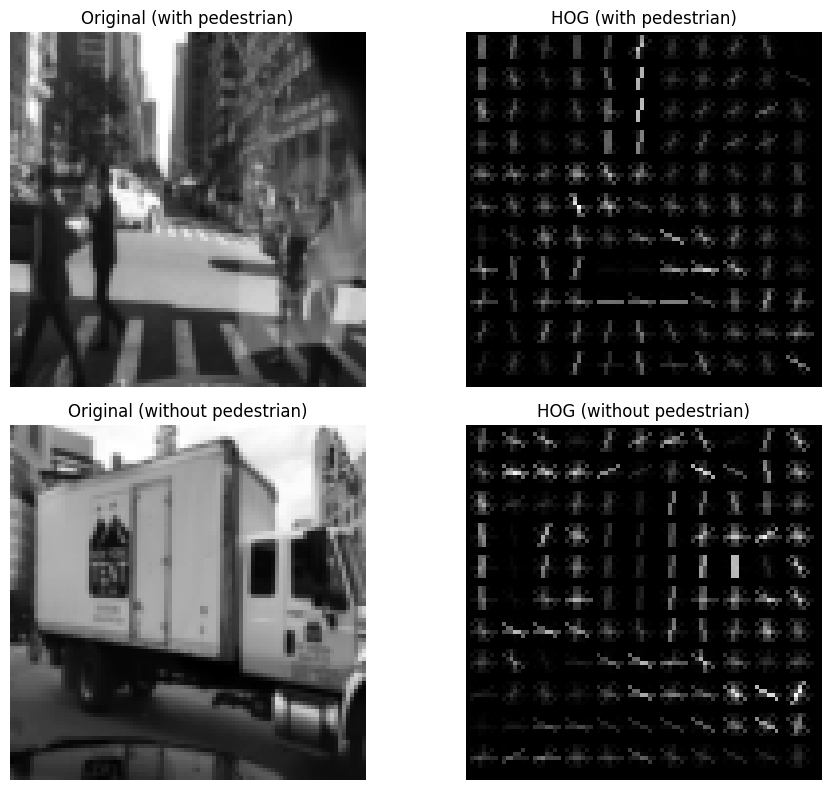

In [5]:
# Function to return both the grayscale and HOG image
def visualize_hog(image_path):
    image = imread(image_path, as_gray=True)
    image = resize(image, (90, 90))  # Small size for better visualization
    _, hog_image = hog(image, orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=True)
    return image, hog_image

# Visualize one pedestrian and one non-pedestrian example
example_with = images_with_people[0]
example_without = images_without_people[0]
img1, hog1 = visualize_hog(example_with)
img2, hog2 = visualize_hog(example_without)

# Display the original and HOG-transformed images
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(img1, cmap='gray'); axs[0, 0].set_title("Original (with pedestrian)")
axs[0, 1].imshow(hog1, cmap='gray'); axs[0, 1].set_title("HOG (with pedestrian)")
axs[1, 0].imshow(img2, cmap='gray'); axs[1, 0].set_title("Original (without pedestrian)")
axs[1, 1].imshow(hog2, cmap='gray'); axs[1, 1].set_title("HOG (without pedestrian)")
for ax in axs.ravel(): ax.axis('off')
plt.tight_layout(); plt.show()

## 5. Train an SVM model using GridSearchCV

In [6]:
# Define a grid of hyperparameters to search over
param_grid = {
    'C': [0.1, 1, 10],         # Regularization parameter
    'gamma': [0.01, 0.1, 1],   # Kernel coefficient for RBF
    'kernel': ['rbf']          # Use RBF kernel
}

# Perform grid search with cross-validation
print("🔧 Searching for best hyperparameters...")
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

🔧 Searching for best hyperparameters...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['rbf']},
             verbose=1)

## 6. Display the best model configuration

In [7]:
best_model = grid_search.best_estimator_
print("\n✅ Best hyperparameter combination:")
print(grid_search.best_params_)


✅ Best hyperparameter combination:
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


## 7. Display the best model configuration

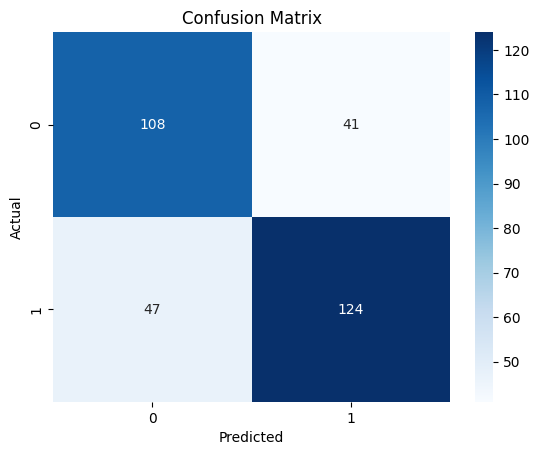


📋 Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       149
           1       0.75      0.73      0.74       171

    accuracy                           0.72       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.73      0.72      0.73       320



In [8]:
# Predict the test set labels
y_pred = best_model.predict(X_test)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Display classification metrics
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Define readable class names
class_names = ['No pedestrian', 'Pedestrian']

## 8. Visualize predictions on test images

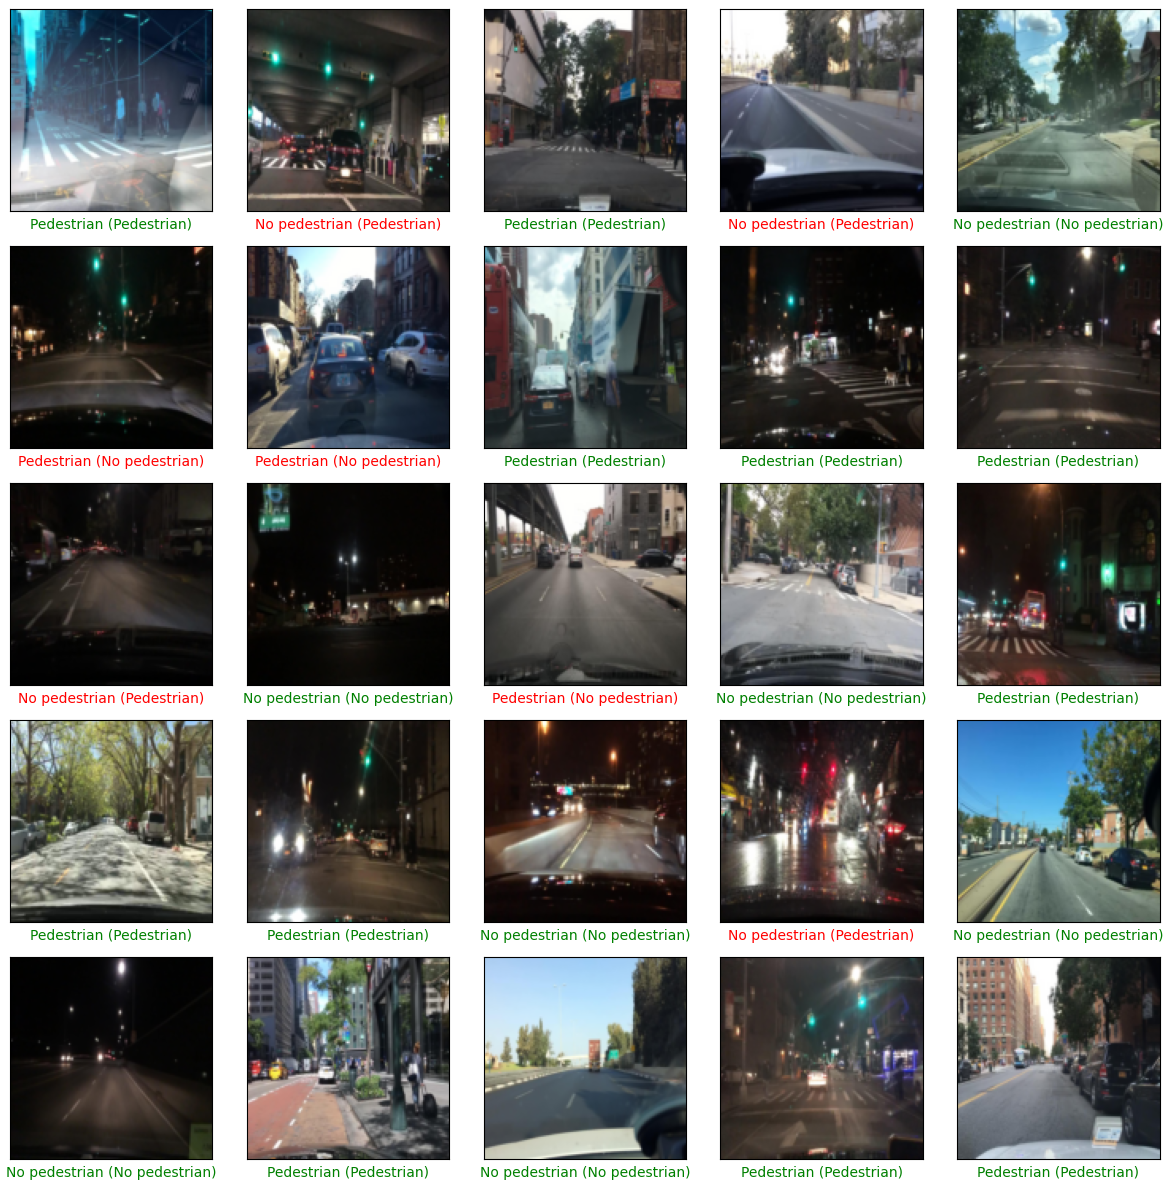

In [9]:
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = imread(x_test_paths[i])
    image = resize(image, (128, 128))
    plt.imshow(image, cmap='gray')

    predicted_label = int(y_pred[i])
    true_label = int(y_test_raw[i])
    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)

plt.tight_layout()
plt.show()